# Objective
Use an Artificial Neural Net to fit a model to classify hand-written digits (MNIST) with PyTorch Lightning.

PyTorch Lightning gives the possibility to structure the PyTorch code. A lot in this notebook is exactly the same as in the classification of MNIST using PyTorch.

Sources:
    
* https://towardsdatascience.com/from-pytorch-to-pytorch-lightning-a-gentle-introduction-b371b7caaf09

# Setup
Import the relevant packages

In [1]:
import os
import pandas as pd
import numpy as np
import random

# packages for modelling and evaluation
import pytorch_lightning as pl
from pytorch_lightning.callbacks import Callback
import torch
from torch import nn
import torch.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
    
# packages for plotting
import matplotlib.pyplot as plt

# set a fixed random state to produce the same results
RANDOM_STATE = 42
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

/home/frauke/anaconda3/lib/python3.8/site-packages/setuptools/distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


# Read Data
    
The data are given in a csv table. The first column is the label, the other coloumns are the pixels of the flattened image.

In [2]:
path = "/home/frauke/GAN/data/MNIST"
data = pd.read_csv(os.path.join(path, "train.csv"))
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Prepare the Data

**Note**:
 
In general 3 datasets are needed. In addition to the here generated training and validation set an independent test set is used for final evaluation of the model.

In [3]:
# generate train and validation set
train_data, valid_data = train_test_split(data, test_size=0.2, shuffle=True, random_state=RANDOM_STATE)
print(f'Data shape after splitting:')
print(f'Train Dataset: {train_data.shape}')
print(f'Validation Dataset: {valid_data.shape}')

Data shape after splitting:
Train Dataset: (33600, 785)
Validation Dataset: (8400, 785)


# Example Plots

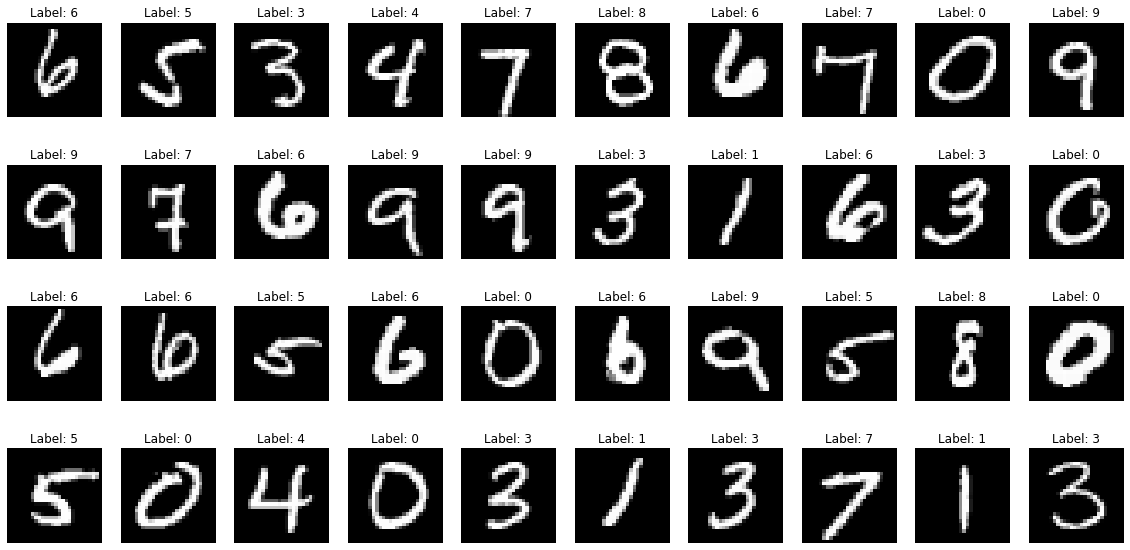

In [4]:
X_train = train_data.iloc[:,1:].values
y_train = train_data.iloc[:,0].values

fig, axes = plt.subplots(4,10, figsize=(20,10))
    
for i, ax in enumerate(axes.flatten()):
    ax.imshow(X_train[i].reshape(28, 28), cmap="gray")
    ax.axis('off')
    ax.set_title(f'Label: {int(y_train[i])}')

# Define the Dataset

**Note:**
    
For MNIST it is possible to directly download the Dataset via ```from torchvision.datasets import MNIST```. In this notebook however a dataset is constructed by hand in order to demonstrate the workflow. 
    
For more detailed information about pytorch datasets see https://github.com/utkuozbulak/pytorch-custom-dataset-examples

In [5]:
class MNISTDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        '''
        data_frame: data as csv data frame
        transform: optional transform to be applied to a sample
        '''
        
        self.X = np.array(dataframe.iloc[:,1:]).astype(float)/255 # normalize the data
        self.y = np.array(dataframe.iloc[:,0]).astype(int)
        # reshape X (#samples, #channels, width, height)
        self.X = self.X.reshape(self.X.shape[0], 28, 28, 1)
        self.transform = transform
        print(f'Data shape: X: {self.X.shape}, y: {self.y.shape}')
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.y[idx]
        
        if self.transform:
            x = self.transform(x)
        return x, y

# Define the Data Module

In the Lightning Data Module the same steps as in plane PyTorch code, but organized in a more structured way:

* prepare_data

This function handles downloads and any data processing. This function makes sure that when you use multiple GPUs you don’t download multiple datasets or apply double manipulations to the data.
This is because each GPU will execute the same PyTorch thereby causing duplication. ALL of the code in Lightning makes sure the critical parts are called from ONLY one GPU.

In this exampe this function is not used and could be ommited. If you use the MNIST data from ```from torchvision.datasets import MNIST``` you might use it in the following way:

```
def prepare_data(self)
    MNIST(os.getcwd(), train=True, download=True, 
    MNIST(os.getcwd(), train=False, download=True)
```

* setup

For operations you want to perform on every GPU (e.g. count number of classes, perform train/val/test splits, 
apply transforms, ...)


* train_dataloader / val_dataloader

Each of these is responsible for returning the appropriate data split. Lightning structures it this way so that it is VERY clear HOW the data are being manipulated. 

This code is organized under what we call a DataModule. Although this is 100% optional and lightning can use DataLoaders directly, a DataModule makes your data reusable and easy to share.

(source: https://towardsdatascience.com/from-pytorch-to-pytorch-lightning-a-gentle-introduction-b371b7caaf09)

Further reading:

https://pytorch-lightning.readthedocs.io/en/stable/extensions/datamodules.html

In [6]:
class MNISTDataModule(pl.LightningDataModule):
    def __init__(self, batch_size=64):
        super().__init__()
        self.batch_size = batch_size
        # transforms
        self.transform = transforms.Compose([transforms.ToTensor()
                                             , transforms.Normalize((0.13101,), (0.30856,))])

    def prepare_data(self):
        pass
    
    def setup(self, stage):
        if stage == 'fit' or stage is None:
        
            self.data_frame_train = train_data
            self.data_frame_valid = valid_data
            
    def train_dataloader(self):
        # create dataset
        train_dataset = MNISTDataset(self.data_frame_train, transform=self.transform)
        # wrap dataset into dataloader
        train_dataloader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True, drop_last=True)

        return train_dataloader
        
    def val_dataloader(self):
        # create dataset
        val_dataset = MNISTDataset(self.data_frame_valid, transform=self.transform)
        # wrap dataset into dataloader
        val_dataloader = DataLoader(val_dataset, batch_size=self.batch_size)
        print(f'val dataloader X: {next(iter(val_dataloader))[0].shape}')
        print(f'val dataloader y: {next(iter(val_dataloader))[1].shape}')

        return val_dataloader

# Define the Model
    
This is a dense neural net using linear layers (https://pytorch.org/docs/stable/generated/torch.nn.Linear.html). 

The model is defined the same way as in plane PyTorch, however optimizer, loss, training and validation loop are included.

<img src="mnist_neural_net_example.png" alt="neural net illustration" width="500"/>


In [7]:
class MNISTClassifierLightning(pl.LightningModule):
    def __init__(self, learning_rate=1e-3):
        super(MNISTClassifierLightning, self).__init__()
        
        # mnist images are (1, 28, 28) (channels, width, height)
        self.layer1 = nn.Linear(28*28, 128) # in_features, out_features
        self.layer2 = nn.Linear(128, 256)
        self.layer3 = nn.Linear(256, 10)
        
        self.learning_rate = learning_rate
        self.accuracy = pl.metrics.Accuracy()
        
    def forward(self, x):
        
        batch_size, channels, width, height = x.size()
        
        x = x.view(batch_size, -1)
        x = self.layer1(x)
        x = torch.relu(x)
        x = self.layer2(x)
        x = torch.relu(x)
        x = self.layer3(x)
        x = torch.log_softmax(x, dim=1)
        
        return x
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer
    
    def cross_entropy_loss(self, y_hat, y):
        criterium = nn.NLLLoss()
        loss = criterium(y_hat, y) 
        return loss
    
    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        y_hat = self.forward(x.float())
        loss = self.cross_entropy_loss(y_hat, y.long())
        acc = self.accuracy(y_hat, y)
        self.log('train_loss', loss, on_step=False, on_epoch=True)
        self.log('train_accuracy', acc, on_step=False, on_epoch=True)
        return loss
        
    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        y_hat = self.forward(x.float())
        loss = self.cross_entropy_loss(y_hat, y.long())
        acc = self.accuracy(y_hat, y)
        self.log('val_loss', loss, on_epoch=True)
        self.log('val_accuracy', acc, on_epoch=True)
        
    def predict_step(self, val_batch, batch_idx):
        x, y = val_batch
        y_pred = self.forward(x.float())
        return y_pred

# Callbacks

Lightning has a callback system to execute callbacks when needed. Callbacks should capture NON-ESSENTIAL logic that is NOT required for your lightning module to run

Further reading: https://pytorch-lightning.readthedocs.io/en/latest/extensions/callbacks.html

In [8]:
class MNISTCallbacks(Callback):
    def __init__(self):
        super().__init__()

    def on_validation_epoch_end(self, trainer, pl_module):
        metrics = trainer.callback_metrics
        epoch = trainer.current_epoch
        print()
        print(f'\nValidation epoch {epoch} end:')
        for key, item in metrics.items():
            print(f'{key}: {item:.4f}')

# Train the Model

The Lightning Trainer handles the training loop details for you, e.g:

* Automatically enabling/disabling grads

* Running the training, validation and test dataloaders

* Calling the Callbacks at the appropriate times

* Putting batches and computations on the correct devices

Here’s the pseudocode for what the trainer does under the hood (showing the train loop only)

```
# put model in train mode
model.train()
torch.set_grad_enabled(True)

losses = []
for batch in train_dataloader:
    # calls hooks like this one
    on_train_batch_start()

    # train step
    loss = training_step(batch)

    # clear gradients
    optimizer.zero_grad()

    # backward
    loss.backward()

    # update parameters
    optimizer.step()

    losses.append(loss)
```

Source and further reading: https://pytorch-lightning.readthedocs.io/en/stable/common/trainer.html

In [9]:
# hyperparamters 
max_epochs = 5
# set device to GPU, if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MNISTClassifierLightning(learning_rate=1e-5)#.to(device)
data_module = MNISTDataModule(batch_size=32)
trainer = pl.Trainer(max_epochs=max_epochs, callbacks=[MNISTCallbacks()])
trainer.fit(model, data_module)
y_pred = trainer.predict(model, data_module.val_dataloader())
y_pred = torch.cat(y_pred)
y_pred = y_pred.argmax(dim=1, keepdim=True)
y_pred = y_pred.detach().cpu().numpy()

/home/frauke/anaconda3/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:115.)
  return torch._C._cuda_getDeviceCount() > 0
/home/frauke/anaconda3/lib/python3.8/site-packages/deprecate/deprecation.py:115: LightningDeprecationWarning: The `Accuracy` was deprecated since v1.3.0 in favor of `torchmetrics.classification.accuracy.Accuracy`. It will be removed in v1.5.0.
  stream(template_mgs % msg_args)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name     | Type     | Params
------------------------

Data shape: X: (8400, 28, 28, 1), y: (8400,)
val dataloader X: torch.Size([32, 1, 28, 28])
val dataloader y: torch.Size([32])


Validation epoch 0 end:
val_loss: 2.3167
val_accuracy: 0.0781


/home/frauke/anaconda3/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Data shape: X: (33600, 28, 28, 1), y: (33600,)


/home/frauke/anaconda3/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(




Validation epoch 0 end:
val_loss: 1.1043
val_accuracy: 0.7765




Validation epoch 1 end:
val_loss: 0.6141
val_accuracy: 0.8592
train_loss: 1.7721
train_accuracy: 0.5682




Validation epoch 2 end:
val_loss: 0.4702
val_accuracy: 0.8811
train_loss: 0.7961
train_accuracy: 0.8305




Validation epoch 3 end:
val_loss: 0.4055
val_accuracy: 0.8912
train_loss: 0.5253
train_accuracy: 0.8722




Validation epoch 4 end:
val_loss: 0.3703
val_accuracy: 0.8975
train_loss: 0.4262
train_accuracy: 0.8889

Data shape: X: (8400, 28, 28, 1), y: (8400,)
val dataloader X: torch.Size([32, 1, 28, 28])
val dataloader y: torch.Size([32])


/home/frauke/anaconda3/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, predict dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


# Plot Predictions
    
Visualize the model's results with some example plots from the validation set.

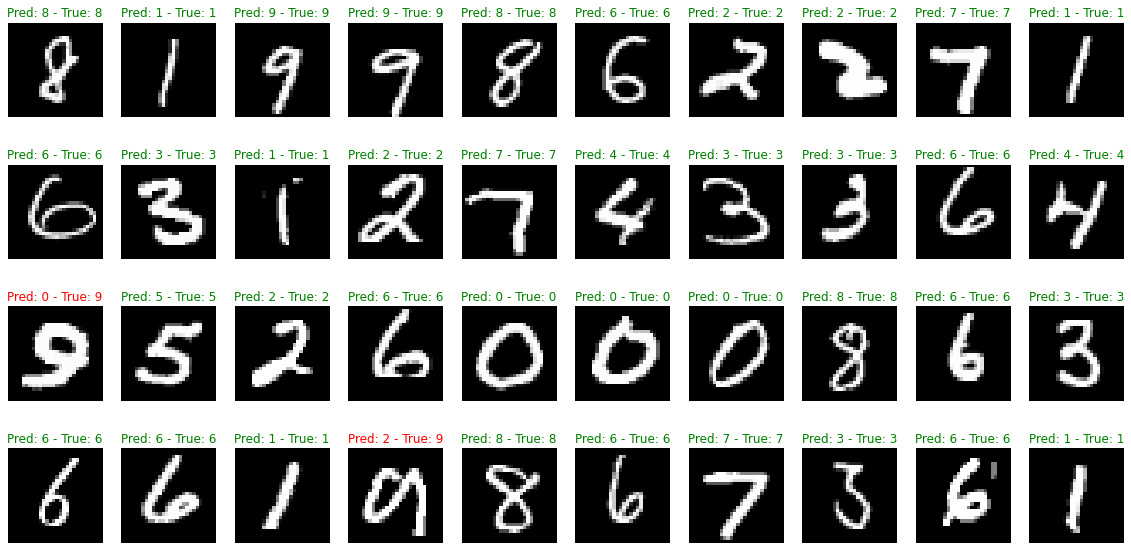

In [10]:
X_valid = valid_data.iloc[:,1:].values
y_valid = valid_data.iloc[:,0].values

fig, axes = plt.subplots(4,10, figsize=(20,10))
    
for i, ax in enumerate(axes.flatten()):
    ax.imshow(X_valid[i].reshape(28, 28), cmap="gray")
    ax.axis('off')
    ax.set_title(f'Pred: {y_pred[i][0]} - True: {int(y_valid[i])}',
                color=("green" if y_pred[i]==y_valid[i] else "red"))